# **Spotify Song Genre Prediction**
#### **DSCI 100 Section 007**
#### **Group 5 Project Proposal**

Feature Descriptions: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features

### Introduction

blah blah blah
* variable description
* variable description
....

### Exploratory Data Analysis

In [21]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 8)

In [22]:
song_data <- read_csv("https://github.com/aidanmeharg/dsci-100-2022W2-group-5/raw/main/data/SpotifyFeatures.csv")

song_data <- song_data |>
    mutate(genre = as_factor(genre)) |> 
    mutate(key = as_factor(key)) |>
    mutate(time_signature = as_factor(time_signature))

song_data

Rows: 232725 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): genre, artist_name, track_name, track_id, key, mode, time_signature
dbl (11): popularity, acousticness, danceability, duration_ms, energy, instr...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<fct>,<dbl>
Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Soul,Jr Thomas & The Volcanos,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM,38,0.0329,0.785,282447,0.683,8.80e-04,E,0.2370,-6.944,Minor,0.0337,113.830,4/4,0.969
Soul,Muddy Waters,(I'm Your) Hoochie Coochie Man,2ziWXUmQLrXTiYjCg2fZ2t,47,0.9010,0.517,166960,0.419,0.00e+00,D,0.0945,-8.282,Major,0.1480,84.135,4/4,0.813
Soul,R.LUM.R,With My Words,6EFsue2YbIG4Qkq8Zr9Rir,44,0.2620,0.745,222442,0.704,0.00e+00,A,0.3330,-7.137,Major,0.1460,100.031,4/4,0.489
Soul,Mint Condition,You Don't Have To Hurt No More,34XO9RwPMKjbvRry54QzWn,35,0.0973,0.758,323027,0.470,4.89e-05,G#,0.0836,-6.708,Minor,0.0287,113.897,4/4,0.479


### Check for Songs Classified Under Multiple Genres

copies,count
<int>,<int>
1,141650
2,21871
3,8091
4,3374
5,1300
6,358
7,124
8,6


[1] 176774

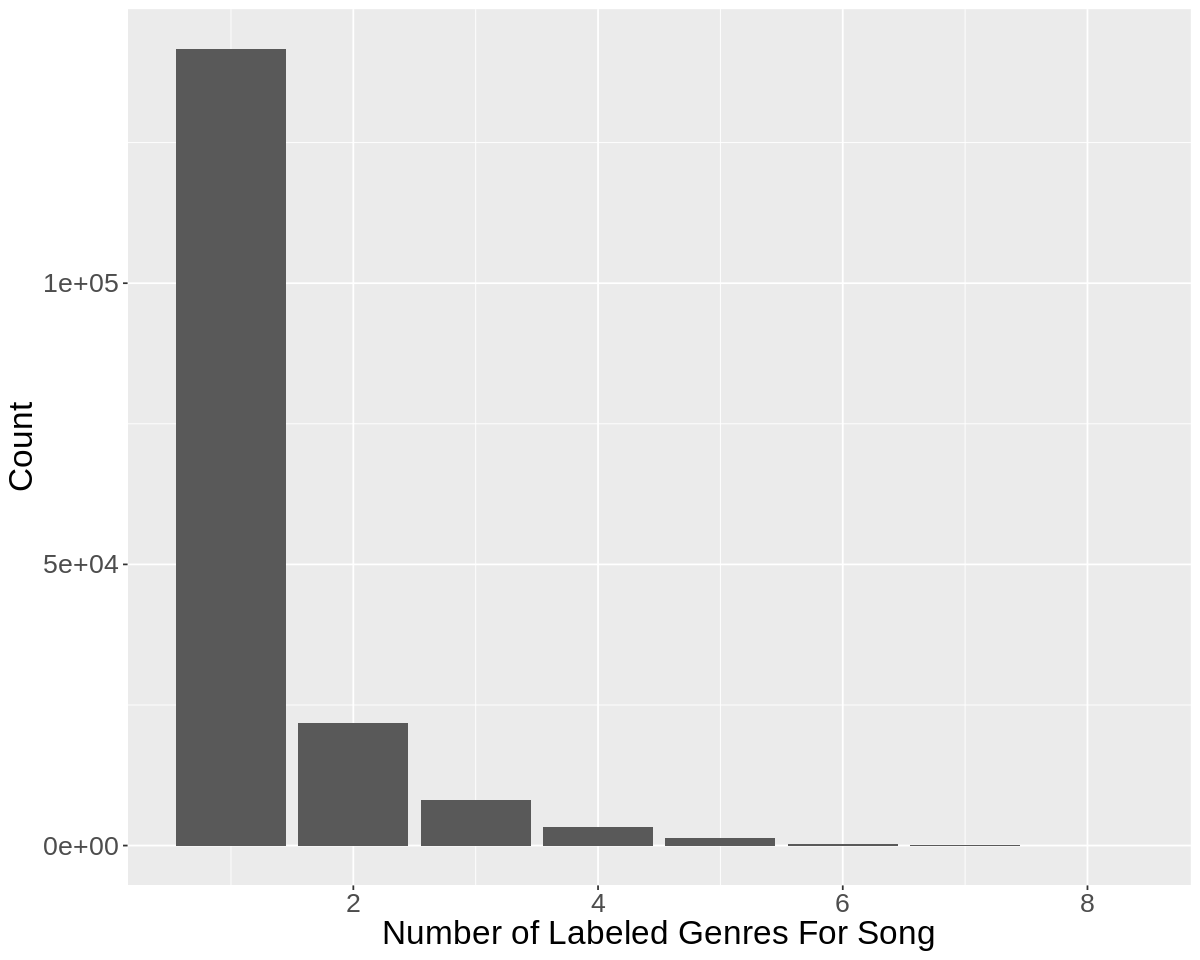

In [23]:
song_copies <- song_data |>
    group_by(track_id) |>
    summarize(copies = n()) |>
    arrange(desc(copies)) 

song_copy_counts <- song_copies |>
    group_by(copies) |>
    summarize(count = n())

num_unique_track_ids <- song_copy_counts |>
    select(count) |>
    pull() |>
    sum()

song_copy_counts
num_unique_track_ids

ggplot(song_copy_counts, aes(copies, count))+
    geom_bar(stat = "identity")+
    labs(x = "Number of Labeled Genres For Song", y = "Count")+
    theme(text = element_text(size = 20))

There are a total of 176,774 unique tracks in this dataset. Of those tracks, 141,650 (a vast majority) fall under a single genre classification while the rest appear in as many as eight different genres! Having songs that fall into multiple genres will complicate the classification process, so for this project we decided to only use songs with one assigned genre.

In [24]:
multi_genre_songs <- song_copies |>
    filter(copies > 1) |>
    select(track_id) |>
    pull()

song_data <- song_data |>
    filter(!(track_id %in% multi_genre_songs))

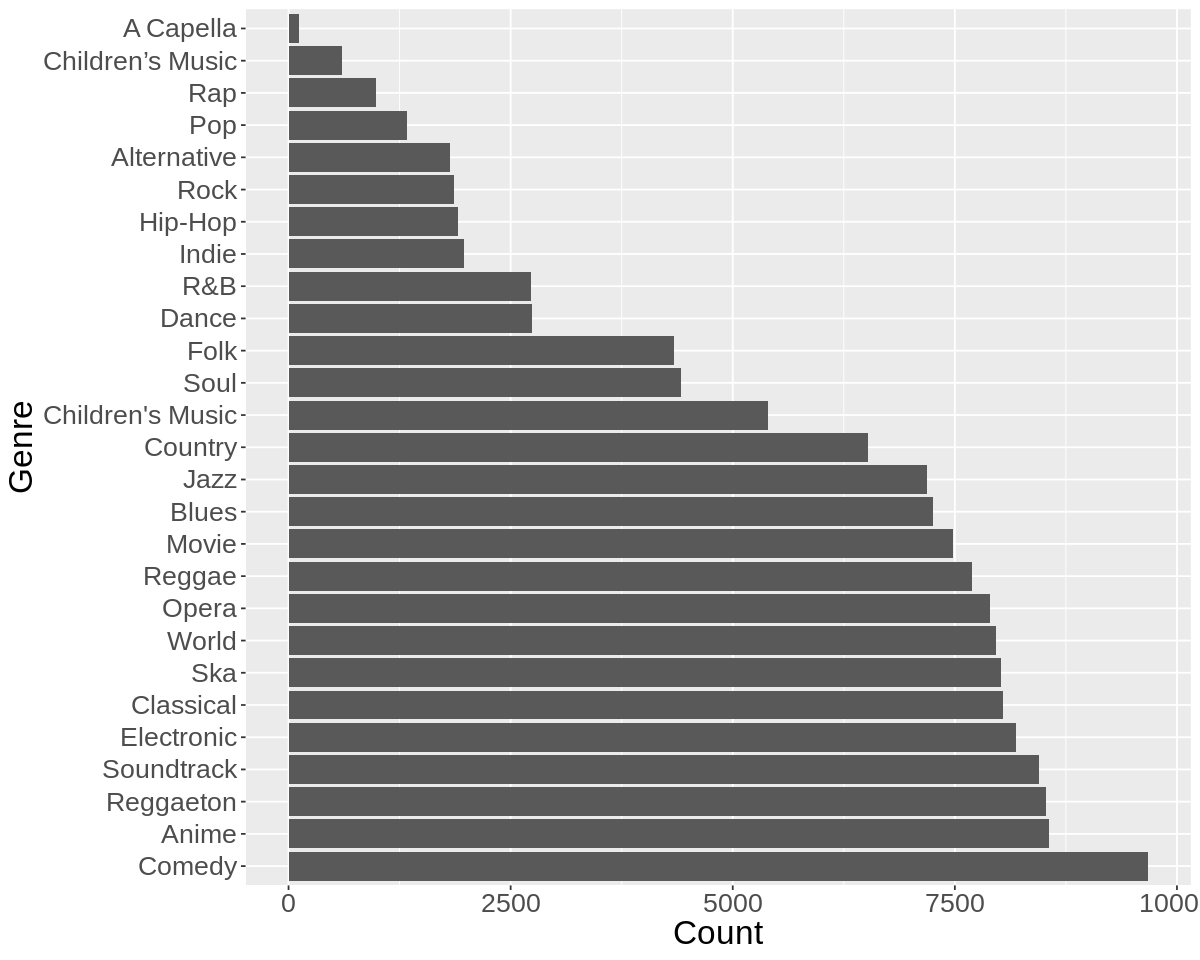

In [25]:
options(repr.plot.height = 8, repr.plot.width = 10)

genre_plot <- song_data |>
    group_by(genre) |>
    summarize(count = n()) |>
    ggplot(aes(reorder(genre, -count), count))+
        geom_bar(stat = "identity")+
        labs(x = "Genre", y = "Count")+
        coord_flip()+
        theme(text = element_text(size = 20))

genre_plot

As seen on the last graph there is a problem regarding the genre of Children's Music as it seems to be classified into two genres because of the apostrophe. One is Children's Music and the other is Children’s Music, we will correct this and put both of them under the same category as they should belong. We also remove A Capella songs from our analysis entirely due to a very low number of observations.

In [27]:
#Checking how many songs and genrea are in the data set
Original_number_Of_songs <-nrow(song_data)
Original_number_Of_Genere <- song_data |>
                            group_by(genre) |>
                            summarize(count = n()) |> 
                            nrow()
print(paste("Number of Rows of the original data set: ", Original_number_Of_songs))
print(paste("Number of genres of the original Data set: ", Original_number_Of_Genere))
#We select one of the two genre classify as children songs and mutate them to the other name of Children's Music
selectingOneTypeOfChildrensSong <- song_data |>
                                filter(genre=="Children’s Music") |>
                                mutate(genre="Children's Music")

#We delete that said genre from the original data set
song_data <- song_data |> 
            filter(genre!="Children’s Music")


[1] "Number of Rows of the original data set:  141046"
[1] "Number of genres of the original Data set:  26"


In [28]:
#We merge both of them into one data set
song_data <-add_row(song_data, selectingOneTypeOfChildrensSong)

#Confirm they have the same number of rows
New_number_of_songs<-nrow(song_data)
print(paste("Number of Rows of the new data set: ", New_number_of_songs))
#Confirm the have one genre less
New_number_Of_Genere <- song_data |>
                            group_by(genre) |>
                            summarize(count = n()) |>
                            nrow()
print(paste("Number of genres of the new Data set: ", New_number_Of_Genere))

[1] "Number of Rows of the new data set:  141046"
[1] "Number of genres of the new Data set:  26"


In [41]:
# Remove the A Capella songs (too few observations!)
song_data <- song_data |>
    filter(genre != "A Capella")

### Training / Testing Split

**Please Don't Forget To Run This**

In [32]:
set.seed(1738)

In [40]:
song_split <- initial_split(song_data, prop = 0.75, strata = genre)
song_train <- training(song_split)
song_test <- testing(song_split)

Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


**Not sure why this warning message keeps occurring**

#### Descriptive Table (training data)

#### Visualization (training data)

### Methods

### Expected Outcomes + Significance